# 12.2b: Fixed-Sigma MPS-Accelerated Trials

**Goal:** Generate 1,000 synthetic snowballs at a specific σ value using GPU acceleration (MPS) to measure statistical distribution of black hole structures.

## Approach

- Generate embeddings in batches on MPS (fast random generation + quantization)
- Move batches to CPU for analysis (torch.unique not implemented on MPS)
- Process in 256-trial batches to keep memory usage reasonable

Best of both worlds: GPU speed for generation, CPU for analysis.

## Parameters

In [1]:
# Experiment parameters
SIGMA = 1.5e-9           # Initialization noise scale (configure this!)
N_TRIALS = 1000        # Number of independent initializations
BATCH_SIZE = 256       # Trials per batch (memory constraint)
N_TOKENS = 2100        # Match Qwen's dead token count
HIDDEN_DIM = 2560      # Qwen's embedding dimension

# Reference scale
EPSILON = 6e-5         # bfloat16 ULP at Qwen magnitude

# Output
OUTPUT_FILE = "../data/analysis/sigma_fixed_trials.csv"

RANDOM_SEED = 42

## Imports

In [2]:
import torch
import numpy as np
import pandas as pd
from safetensors.torch import load_file
from tqdm.auto import tqdm
from pathlib import Path
import time
import gc

torch.manual_seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

# Setup device
if torch.backends.mps.is_available():
    device = torch.device('mps')
    print("✓ MPS (Metal Performance Shaders) available")
else:
    device = torch.device('cpu')
    print("⚠ MPS not available, using CPU only")

print(f"  Device: {device}")

✓ MPS (Metal Performance Shaders) available
  Device: mps


## Load Qwen Centroid

In [3]:
print("\nLoading Qwen black hole centroid...\n")

centroid_data = load_file("../data/tensors/black_hole_centroid_qwen3_4b.safetensors")
qwen_centroid = centroid_data['centroid'].to(torch.float32).to(device)

print(f"✓ Centroid loaded to {device}")
print(f"  Shape: {qwen_centroid.shape}")
print(f"  Norm: {qwen_centroid.norm().item():.6f}")


Loading Qwen black hole centroid...

✓ Centroid loaded to mps
  Shape: torch.Size([2560])
  Norm: 0.166061


## Process in Batches

In [4]:
print(f"\nProcessing {N_TRIALS:,} trials in batches of {BATCH_SIZE}...")
print(f"  σ = {SIGMA:.2e} ({SIGMA/EPSILON:.4f}× ε)")
print(f"  Batch shape: [{BATCH_SIZE}, {N_TOKENS}, {HIDDEN_DIM}]")
print(f"  Generation device: {device}")
print(f"  Analysis device: cpu\n")

n_batches = (N_TRIALS + BATCH_SIZE - 1) // BATCH_SIZE
results = []
trial_counter = 0

total_start = time.time()

for batch_idx in tqdm(range(n_batches), desc="Processing batches"):
    # Determine actual batch size (last batch might be smaller)
    current_batch_size = min(BATCH_SIZE, N_TRIALS - batch_idx * BATCH_SIZE)
    
    # Generate batch on MPS
    noise = torch.randn(current_batch_size, N_TOKENS, HIDDEN_DIM, dtype=torch.float32, device=device) * SIGMA
    embeddings_batch = qwen_centroid.unsqueeze(0).unsqueeze(0) + noise
    embeddings_batch = embeddings_batch.to(torch.bfloat16).to(torch.float32)
    
    # Move to CPU for analysis
    embeddings_cpu = embeddings_batch.to('cpu')
    
    # Analyze each trial in batch
    for i in range(current_batch_size):
        embeddings = embeddings_cpu[i]  # [n_tokens, hidden_dim]
        
        # Find unique vectors
        unique_vectors, inverse_indices, counts = torch.unique(
            embeddings,
            dim=0,
            return_inverse=True,
            return_counts=True
        )
        
        # Black holes (count ≥ 2)
        black_hole_mask = counts >= 2
        n_black_holes = black_hole_mask.sum().item()
        black_hole_population = counts[black_hole_mask].sum().item() if n_black_holes > 0 else 0
        largest_bh = counts.max().item()
        n_singletons = len(unique_vectors) - n_black_holes
        
        # Pairwise L∞ distances (only if multiple black holes)
        if n_black_holes > 1:
            black_hole_vectors = unique_vectors[black_hole_mask]
            v1 = black_hole_vectors.unsqueeze(1)
            v2 = black_hole_vectors.unsqueeze(0)
            diffs = v1 - v2
            l_inf_distances = torch.abs(diffs).max(dim=2)[0]
            
            mask = ~torch.eye(n_black_holes, dtype=torch.bool)
            l_inf_nondiag = l_inf_distances[mask]
            
            max_l_inf = l_inf_nondiag.max().item()
            mean_l_inf = l_inf_nondiag.mean().item()
            median_l_inf = l_inf_nondiag.median().item()
        else:
            max_l_inf = 0.0
            mean_l_inf = 0.0
            median_l_inf = 0.0
        
        results.append({
            'trial': trial_counter,
            'sigma': SIGMA,
            'unique_vectors': len(unique_vectors),
            'n_black_holes': n_black_holes,
            'black_hole_population': black_hole_population,
            'n_singletons': n_singletons,
            'largest_bh': largest_bh,
            'max_l_inf': max_l_inf,
            'mean_l_inf': mean_l_inf,
            'median_l_inf': median_l_inf,
        })
        trial_counter += 1
    
    # Cleanup
    del embeddings_batch, embeddings_cpu, noise
    gc.collect()

total_time = time.time() - total_start

print(f"\n✓ Processing complete in {total_time:.2f}s")
print(f"  Per trial: {total_time / N_TRIALS * 1000:.1f}ms")


Processing 1,000 trials in batches of 256...
  σ = 1.50e-09 (0.0000× ε)
  Batch shape: [256, 2100, 2560]
  Generation device: mps
  Analysis device: cpu



Processing batches:   0%|          | 0/4 [00:00<?, ?it/s]


✓ Processing complete in 13.92s
  Per trial: 13.9ms


## Save Results

In [5]:
df = pd.DataFrame(results)

# Add metadata columns
df['n_tokens'] = N_TOKENS
df['hidden_dim'] = HIDDEN_DIM
df['epsilon'] = EPSILON
df['sigma_over_epsilon'] = df['sigma'] / EPSILON
df['max_l_inf_over_epsilon'] = df['max_l_inf'] / EPSILON

# Save
output_path = Path(OUTPUT_FILE)
output_path.parent.mkdir(parents=True, exist_ok=True)
df.to_csv(output_path, index=False)

print(f"\n✓ Results saved to {output_path}")
print(f"  Rows: {len(df):,}")
print(f"  File size: {output_path.stat().st_size / 1024:.1f} KB")


✓ Results saved to ../data/analysis/sigma_fixed_trials.csv
  Rows: 1,000
  File size: 147.0 KB


## Statistical Summary

In [6]:
print(f"\n{'='*60}")
print(f"STATISTICAL SUMMARY")
print(f"{'='*60}")
print(f"Trials: {N_TRIALS:,}")
print(f"σ = {SIGMA:.2e} ({SIGMA/EPSILON:.4f}× ε)")
print(f"\nBlack hole count (C):")
print(f"  Mean: {df['n_black_holes'].mean():.1f}")
print(f"  Median: {df['n_black_holes'].median():.1f}")
print(f"  Std: {df['n_black_holes'].std():.1f}")
print(f"  Range: [{df['n_black_holes'].min()}, {df['n_black_holes'].max()}]")
print(f"\nBlack hole population (P):")
print(f"  Mean: {df['black_hole_population'].mean():.1f}")
print(f"  Median: {df['black_hole_population'].median():.1f}")
print(f"  Std: {df['black_hole_population'].std():.1f}")
print(f"  Range: [{df['black_hole_population'].min()}, {df['black_hole_population'].max()}]")
print(f"\nMax L∞ / ε:")
print(f"  Mean: {df['max_l_inf_over_epsilon'].mean():.2f}")
print(f"  Median: {df['max_l_inf_over_epsilon'].median():.2f}")
print(f"  Std: {df['max_l_inf_over_epsilon'].std():.2f}")
print(f"  Range: [{df['max_l_inf_over_epsilon'].min():.2f}, {df['max_l_inf_over_epsilon'].max():.2f}]")

# Target matching
c13_count = (df['n_black_holes'] == 13).sum()
p2100_count = ((df['black_hole_population'] >= 2000) & (df['black_hole_population'] <= 2200)).sum()
both_count = ((df['n_black_holes'] == 13) & (df['black_hole_population'] >= 2000) & (df['black_hole_population'] <= 2200)).sum()

print(f"\nQwen target matching:")
print(f"  C = 13: {c13_count} / {N_TRIALS} ({c13_count / N_TRIALS * 100:.1f}%)")
print(f"  P ≈ 2100: {p2100_count} / {N_TRIALS} ({p2100_count / N_TRIALS * 100:.1f}%)")
print(f"  Both C=13 AND P≈2100: {both_count} / {N_TRIALS} ({both_count / N_TRIALS * 100:.1f}%)")

print(f"{'='*60}")


STATISTICAL SUMMARY
Trials: 1,000
σ = 1.50e-09 (0.0000× ε)

Black hole count (C):
  Mean: 12.8
  Median: 13.0
  Std: 1.1
  Range: [10, 17]

Black hole population (P):
  Mean: 2096.6
  Median: 2097.0
  Std: 1.6
  Range: [2091, 2100]

Max L∞ / ε:
  Mean: 0.20
  Median: 0.25
  Std: 0.10
  Range: [0.01, 0.25]

Qwen target matching:
  C = 13: 383 / 1000 (38.3%)
  P ≈ 2100: 1000 / 1000 (100.0%)
  Both C=13 AND P≈2100: 383 / 1000 (38.3%)


## Distribution Histograms

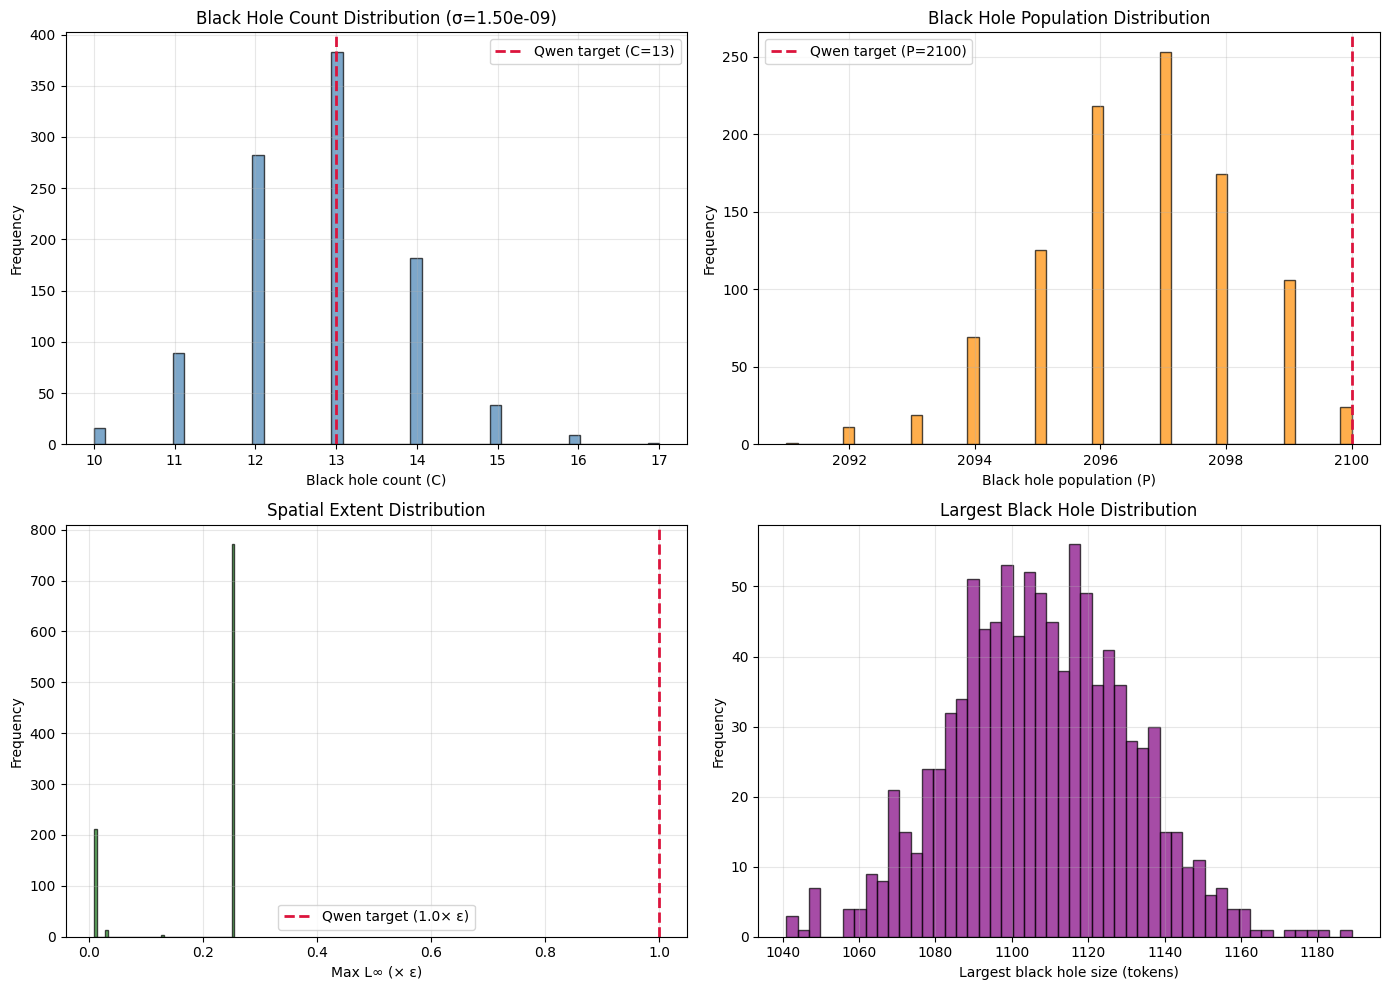

In [7]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 2, figsize=(14, 10), dpi=100)

# Black hole count distribution
ax = axes[0, 0]
ax.hist(df['n_black_holes'], bins=50, color='steelblue', alpha=0.7, edgecolor='black')
ax.axvline(13, color='crimson', linestyle='--', linewidth=2, label='Qwen target (C=13)')
ax.set_xlabel('Black hole count (C)')
ax.set_ylabel('Frequency')
ax.set_title(f'Black Hole Count Distribution (σ={SIGMA:.2e})')
ax.legend()
ax.grid(True, alpha=0.3)

# Black hole population distribution
ax = axes[0, 1]
ax.hist(df['black_hole_population'], bins=50, color='darkorange', alpha=0.7, edgecolor='black')
ax.axvline(2100, color='crimson', linestyle='--', linewidth=2, label='Qwen target (P=2100)')
ax.set_xlabel('Black hole population (P)')
ax.set_ylabel('Frequency')
ax.set_title('Black Hole Population Distribution')
ax.legend()
ax.grid(True, alpha=0.3)

# Max L∞ distribution
ax = axes[1, 0]
ax.hist(df['max_l_inf_over_epsilon'], bins=50, color='forestgreen', alpha=0.7, edgecolor='black')
ax.axvline(1.0, color='crimson', linestyle='--', linewidth=2, label='Qwen target (1.0× ε)')
ax.set_xlabel('Max L∞ (× ε)')
ax.set_ylabel('Frequency')
ax.set_title('Spatial Extent Distribution')
ax.legend()
ax.grid(True, alpha=0.3)

# Largest black hole size
ax = axes[1, 1]
ax.hist(df['largest_bh'], bins=50, color='purple', alpha=0.7, edgecolor='black')
ax.set_xlabel('Largest black hole size (tokens)')
ax.set_ylabel('Frequency')
ax.set_title('Largest Black Hole Distribution')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()